## Digital Image Processing, ECE419

Ernesto Colon

The Cooper Union Department of Electrical Engineering


February 2nd, 2021

References:
- Digital Image Processing Using Matlab [DIPUM] by Gonzalez et al., 3rd ed
- Digital Image Processing by Gonzalez et al., 4th ed

**The following set of notes and example scripts are part of my independent study sessions and adapted from the references outlined above. My main reference is DIPUM and complemented with online documentation. As I go through the theory and textbook examples, I am translating the code and image processing techniques to Python.**

## Frequency Domain Filtering Notes/Exercises/Sandbox

In [1]:
#Importing the libraries
import sys
#sys.path.append('C:/Users/ernes/OneDrive - The Cooper Union for the Advancement of Science and Art/Digital Image Processing-Aurora-R11/DIPUM/Scripts/Digital-Image-Processing')
sys.path.append('..')

import numpy as np
import os
import matplotlib.pyplot as plt
#from ec_img_utils import *
import ec_img_utils
from tabulate import tabulate
import skimage
import skimage.util
from skimage import io
import scipy.fft

**Computing and visualizing the 2-D Fourier Transform**

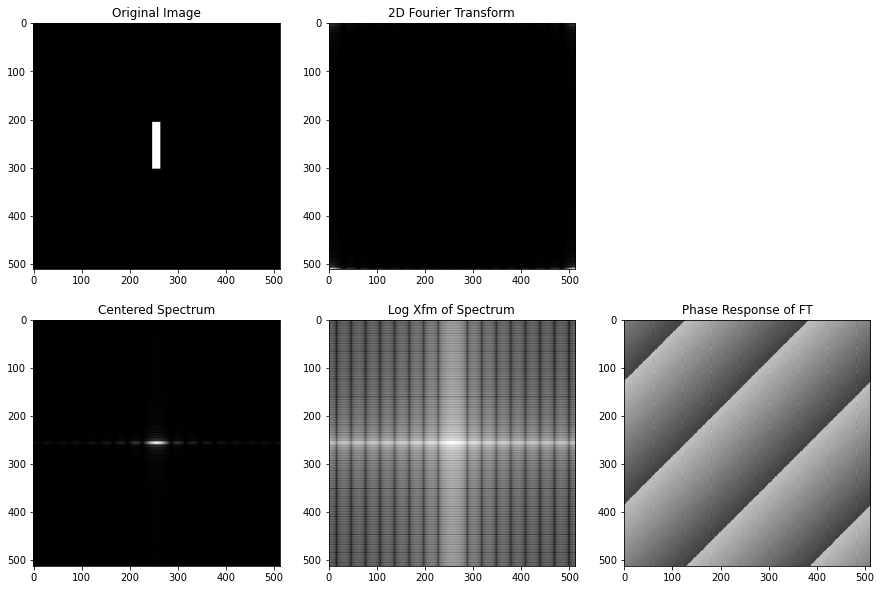

In [2]:
#import vertical bar image
img_vert_bar = io.imread('./images/vertical-bar.tif')

#display the original image
fig_vert_bar, ax_vert_bar = plt.subplots(2,3,figsize = (15,10))
ax_vert_bar = ax_vert_bar.ravel()

ax_vert_bar[0].imshow(img_vert_bar, cmap = 'gray'); ax_vert_bar[0].set_title('Original Image');

#Compute the 2D Fourier Transform
ft_vert_bar = scipy.fft.fft2(img_vert_bar)

#compute the spectrum 
spec_vert_bar = np.abs(ft_vert_bar)

#display the computed 2D FT
ax_vert_bar[1].imshow(skimage.img_as_float(spec_vert_bar), cmap = 'gray'); ax_vert_bar[1].set_title('2D Fourier Transform');

#Because of the periodic nature of the Discrete Fourier Transform, we get the four bright spots in the corners. Let's shift/center the spectrum
ft_ctr_vert_bar = scipy.fft.fftshift(ft_vert_bar)
spec_ctr_vert_bar = np.abs(ft_ctr_vert_bar)

#display shifted spectrum
ax_vert_bar[3].imshow(spec_ctr_vert_bar,cmap = 'gray'); ax_vert_bar[3].set_title('Centered Spectrum');

#As discussed in Chapter 3, the dynamic range of the Fourier Transform can be extremely large. Applying a log transformation to our image improves our ability to visualize the spectrum
spec_log_vert = ec_img_utils.log_xfm(spec_ctr_vert_bar, {})
ax_vert_bar[4].imshow(spec_log_vert, cmap = 'gray'); ax_vert_bar[4].set_title('Log Xfm of Spectrum');

#Compute the phase response of our 2D Fourier Transform. We use arctan2() from numpy to compute the four-quadrant arctangent
phs_vert_bar = np.arctan2(np.real(ft_vert_bar), np.imag(ft_vert_bar))
ax_vert_bar[5].imshow(phs_vert_bar, cmap = 'gray'); ax_vert_bar[5].set_title('Phase Response of FT');

fig_vert_bar.delaxes(ax_vert_bar[2])

### Filtering in the Frequency Domain

**Example 4.1 from DIPUM - Effects of filtering with and without padding**

Image Information

 | Shape      | Data type   |   Bytes |   Range |
|------------|-------------|---------|---------|
| (600, 600) | uint8       |  360000 |       0 |
|            |             |         |     255 |

Padded FFT size is:  (1200, 1200)

Gaussian LPF transfer function for padded FFT has size:  (1200, 1200) 



Text(0.5, 1.0, 'LPF with padding')

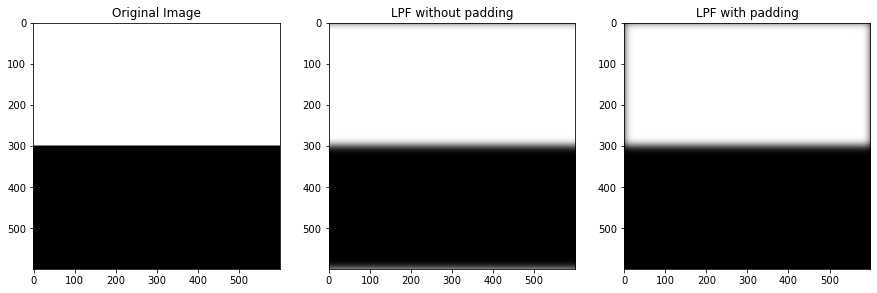

In [3]:
#first filter in the frequency domain without padding

#load two stripes image
img_two_strp = io.imread('./images/two-stripes.tif')

#print image information
ec_img_utils.get_img_info(img_two_strp)

#display the image
fig_tw_strp, ax_two_strp = plt.subplots(1,3, figsize = (15,5))

ax_two_strp = ax_two_strp.ravel()

ax_two_strp[0].imshow(img_two_strp, cmap = 'gray'); ax_two_strp[0].set_title('Original Image');

#Compute the 2D FT of the image
M,N = img_two_strp.shape
ft_two_strp = scipy.fft.fft2(img_two_strp)
gauss_sig = 10
lpf_gauss_H1 = ec_img_utils.lp_gaussian(M,N,gauss_sig)

filt_two_strp = lpf_gauss_H1 * ft_two_strp

#compute inverse FT
ift_two_strp = scipy.fft.ifft2(filt_two_strp)

#display image
ax_two_strp[1].imshow(np.real(ift_two_strp), cmap = 'gray');
ax_two_strp[1].set_title('LPF without padding')

#note the presence of black borders in the filtered image due to the periodic nature of the FT

#filtering with padding now

#get padded dimensions using utility function padded_size - adapted from DIPUM
padded_dim = ec_img_utils.padded_size({'img_dim':img_two_strp.shape})

#compute the FFT with zero padding
ft_two_strp_padded = scipy.fft.fft2(img_two_strp, s = padded_dim)

#confirm that the FFT size
print("\nPadded FFT size is: ", ft_two_strp_padded.shape)

#Get Gaussian LPF transfer function
lpf_gauss_H2 = ec_img_utils.lp_gaussian(padded_dim[0],padded_dim[1],2*gauss_sig)

#confirm Guassian LPF transfer function has the right size
print("\nGaussian LPF transfer function for padded FFT has size: ", lpf_gauss_H2.shape,"\n")

#Frequency domain filtering
filt_two_strp_padded = ft_two_strp_padded * lpf_gauss_H2

#compute inverse FT
ift_two_strp_padded = scipy.fft.ifft2(filt_two_strp_padded)

#Crop image back to the original size
ift_two_strp_padded = ift_two_strp_padded[0:img_two_strp.shape[0], 0:img_two_strp.shape[1]]

#display image
ax_two_strp[2].imshow(np.real(ift_two_strp_padded), cmap = 'gray');
ax_two_strp[2].set_title('LPF with padding')

Note that the image without padding only has a black border along the top and bottom edge, not in the vertical directions. This is due to the periodic nature of the 2D FT. On the other hand, when we padded the image with zeros prior to computing the FFT, we see that we now have a uniform grayish border. Of course, this is not desirable in some cases, like the example above. The key point is that we can compute a power of two padded dimension and then use other padding methods (e.g., symmetric warp, extensions, etc.) to process our images. 

### Lowpass (smoothing) frequency domain filter transfer functions

An ideal lowpass filter has the following transfer function:

\begin{array}{ll}
     H(u,v) =  1 & if ~~D(u,v) \leq D_0 \\
      H(u,v) = 0 & if ~~ D(u,v) > D_0 \\
\end{array}

Where $D_0$ is a positive number and $D(u,v)$ is the distance from point $(u,v)$ to the center of the transfer function.

Text(0.5, 1.0, 'Ideal LPF')

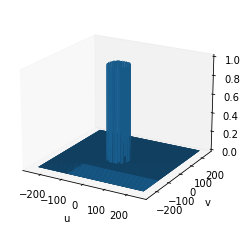

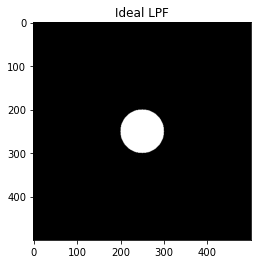

In [4]:
# Plotting the transfer function of LPF's
from matplotlib import cm

# Get meshgrid for plotting
U, V = ec_img_utils.dftuv(500,500)

# Ideal LPF filter
H_ideal = ec_img_utils.lp_filter('ideal', 500, 500, 50)

# shift spectrum
H_ideal_shft = scipy.fft.fftshift(H_ideal).astype(int)

fig_lpf_ideal = plt.figure()

ax_lpf_ideal = fig_lpf_ideal.add_subplot(1, 1, 1, projection = '3d')
ideal_surf = ax_lpf_ideal.plot_surface(U, V, H_ideal)
ax_lpf_ideal.set_xlabel('u')
ax_lpf_ideal.set_ylabel('v')
ax_lpf_ideal.view_init(20)
ax_lpf_ideal.grid(False)
#ax_lpf1.zaxis.set_ticklabels([])
#ax_lpf1.w_zaxis.line.set_lw(0.)
#ax_lpf1.set_xlim(-10.0, 10.0)
#ax_lpf1.set_ylim(-10.0, 10.0)
#ax_lpf1.set_zlim(0, 1.0)

# Display 2D ideal LPF as an image
fig_lpf_ideal2, ax_lpf_ideal2 = plt.subplots(1, 1)
ax_lpf_ideal2.imshow(H_ideal_shft, cmap = 'gray'); ax_lpf_ideal2.set_title('Ideal LPF')

From the 3D plot and ideal LPF imag shown above, we see that the ideal LPF essentially masks out any frequency components outside of its passband.

Next, we explore a Butterworth filter with a smoother transition relative to our 'brickwall' ideal LPF. A Butterworth filter has the following transfer function:

\begin{equation}
H(u,v) = \frac{1}{1 + ( \frac{D(u,v)}{D_0})^{2n})}
\end{equation}

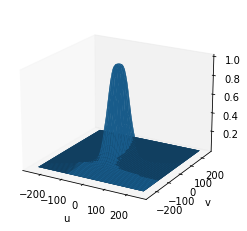

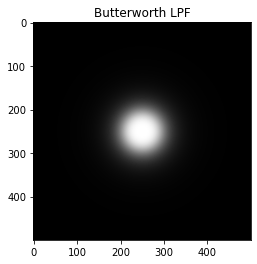

In [5]:
# Butterworth LPF filter
H_butterworth = ec_img_utils.lp_filter('butterworth', 500, 500, 50, 2)

# shift spectrum
H_butterworth_shft = scipy.fft.fftshift(H_butterworth)

fig_lpf_bttr = plt.figure()

ax_lpf_bttr = fig_lpf_bttr.add_subplot(1, 1, 1, projection = '3d')
bttr_surf = ax_lpf_bttr.plot_surface(U, V, H_butterworth)
ax_lpf_bttr.set_xlabel('u')
ax_lpf_bttr.set_ylabel('v')
ax_lpf_bttr.view_init(20)
ax_lpf_bttr.grid(False)

# Display 2D ideal LPF as an image
fig_lpf_bttr2, ax_lpf_bttr2 = plt.subplots(1, 1)
ax_lpf_bttr2.imshow(H_butterworth_shft, cmap = 'gray'); ax_lpf_bttr2.set_title('Butterworth LPF');

From the Butterworth image shown above, we see that the transition from passband to stopband is more gradual.

A Gaussian lowpass filter has the following form:

\begin{equation}
H(u,v) = e^{-D^2(u,v)/2\sigma^2}
\end{equation}

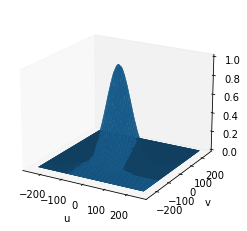

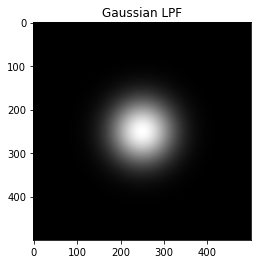

In [6]:
# Butterworth LPF filter
H_gauss = ec_img_utils.lp_filter('gaussian', 500, 500, 50)

# shift spectrum
H_gauss_shft = scipy.fft.fftshift(H_gauss)

fig_lpf_gauss = plt.figure()

ax_lpf_gauss = fig_lpf_gauss.add_subplot(1, 1, 1, projection = '3d')
gauss_surf = ax_lpf_gauss.plot_surface(U, V, H_gauss)
ax_lpf_gauss.set_xlabel('u')
ax_lpf_gauss.set_ylabel('v')
ax_lpf_gauss.view_init(20)
ax_lpf_gauss.grid(False)

# Display 2D ideal LPF as an image
fig_lpf_gauss2, ax_lpf_gauss2 = plt.subplots(1, 1)
ax_lpf_gauss2.imshow(H_gauss_shft, cmap = 'gray'); ax_lpf_gauss2.set_title('Gaussian LPF');

Note that the Gaussian filter has a wider transition than the Butterworth filter.

**Example 4.4 from DIPUM - Lowpass filtering**

In [7]:
# Load test pattern image
img_tst_pttrn = io.imread('./images/testpattern512.tif')

# Compute padding dimensions
tst_pttrn_pad_dim = ec_img_utils.padded_size({"img_dim": img_tst_pttrn.shape})

#Ideal LPI
D0 = 50
tst_HLPI = ec_img_utils.lp_filter('ideal', tst_pttrn_pad_dim[0], tst_pttrn_pad_dim[1], D0)

#filter the image
tst_LPI = ec_img_utils.dft_filt(img_tst_pttrn, tst_HLPI, 'constant')

ValueError: operands could not be broadcast together with shapes (3584,3584) (1024,1024) 

In [8]:
print(tst_pttrn_pad_dim)

[1024 1024]


In [9]:
test = ec_img_utils.padded_size({"img_dim": img_tst_pttrn.shape, "krnl_dim": tst_HLPI.shape, "pwr2":True})